In [0]:
import torch
from torch import nn
from torch.autograd import Variable
import copy
import math
import sys
import torch.optim as optim
from torchtext import data
import spacy
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import json
from copy import deepcopy
import re

In [0]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Embeddings(nn.Module):

    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x)
#         return self.lut(x) * math.sqrt(self.d_model)
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(torch.as_tensor(position.numpy() * div_term.unsqueeze(0).numpy()))
        pe[:, 1::2] = torch.cos(torch.as_tensor(position.numpy() * div_term.unsqueeze(0).numpy()))#torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [0]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):

        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):

        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
     
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [0]:
class Encoder(nn.Module):

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class EncoderLayer(nn.Module):

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(size, dropout), 4)
        self.size = size

    def forward(self, x, mask=None):

        x = self.sublayer_output[0](x, lambda x: self.self_attn(x, x, x, mask)) # Encoder self-attention
        return self.sublayer_output[1](x, self.feed_forward)

In [0]:
from torch import nn
import torch.nn.functional as F

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [0]:
def get_training_accuracy(y_pred, y):
  all_preds = []
  all_y = []
  predicted = torch.max(y_pred.cpu().data, 1)[1]
  all_preds.extend(predicted.numpy())
  all_y.extend(y.cpu().numpy())
  score = accuracy_score(all_y, np.array(all_preds).flatten())
  return score

class Transformer(nn.Module):
    def __init__(self, config, src_vocab):
        super(Transformer, self).__init__()
        self.config = config
        
        h, N, dropout = self.config.h, self.config.N, self.config.dropout
        d_model, d_ff = self.config.d_model, self.config.d_ff
        
        attn = MultiHeadedAttention(h, d_model)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        position = PositionalEncoding(d_model, dropout)
        
        self.encoder = Encoder(EncoderLayer(config.d_model, deepcopy(attn), deepcopy(ff), dropout), N)
        self.src_embed = nn.Sequential(Embeddings(config.d_model, src_vocab), deepcopy(position))
        self.fc = nn.Linear(
            self.config.d_model,
            self.config.output_size
        )

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded_sents = self.src_embed(x.permute(1,0))
        encoded_sents = self.encoder(embedded_sents)

        final_feature_map = encoded_sents[:,-1,:]
        final_out = self.fc(final_feature_map)
        return self.softmax(final_out)
    
    def add_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def add_loss_op(self, loss_op):
        self.loss_op = loss_op
    
    def reduce_lr(self):
        for g in self.optimizer.param_groups:
            g['lr'] = g['lr'] / 2
                
    def run_epoch(self, train_iterator, val_iterator, epoch):
        train_losses = []
        train_accuracies = []
        val_accuracies = []
        losses = []

        if (epoch == int(self.config.max_epochs/3)) or (epoch == int(2*self.config.max_epochs/3)):
            self.reduce_lr()
            
        for i, batch in enumerate(train_iterator):
            self.optimizer.zero_grad()
            if torch.cuda.is_available():
                x = batch.claim.cuda()
                y = (batch.label).type(torch.cuda.LongTensor)
            else:
                x = batch.claim
                y = (batch.label).type(torch.LongTensor)
            y_pred = self.__call__(x)
            loss = self.loss_op(y_pred, y)

            loss.backward()
            losses.append(loss.item())
            self.optimizer.step()
    
            if i % 100 == 0 and i != 0:
                print("Iter: {}".format(i+1))
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                score = get_training_accuracy(y_pred, y)
                print('\ttraining accuracy: ', score)
                train_accuracies.append(score)
                losses = []
                
                # Evalute Accuracy on validation set
                val_accuracy = evaluate_model(self, val_iterator)
                val_accuracies.append(val_accuracy)
                print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                self.train()
                
        return train_losses, val_accuracies, train_accuracies

In [0]:
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerOutput(nn.Module):

    def __init__(self, size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [8]:
def preprocess_articles():
    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')
    from sklearn.feature_extraction.text import TfidfVectorizer

    # load metadata
    with open("train.json", 'r') as f:
        metadata = json.load(f)
    n_claims = len(metadata)

    # load related articles for each claim
    relevant_sentences = []
    for id in range(n_claims):

        if id % 500 == 0:
            print("Claims preprocessed: ", id)

        # retrieve related articles
        related_articles = metadata[id]['related_articles']
        articles = ""
        for article_id in related_articles:
            filename = "train_articles/" + str(article_id) + ".txt"
            # concatenate related articles
            with open(filename, 'r') as text_file:
                text = text_file.read()
                articles = articles + "\n" + text

        # split articles into sentences
        sentences = sent_tokenize(articles)

        # append claim to articles
        sentences.append(metadata[id]['claim'])

        # vectorize sentences based on tf-idf
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(sentences)

        # measure similarity between claim and each sentence
        similarity = X[-1, :] @ np.transpose(X[:-2, :])
        similarity = similarity.todense()

        # find top 5 sentences with greatest similarity
        sorted_index = np.argsort(similarity)
        top_sentences = []
        for i in range(1, min(5, sorted_index.shape[1]) + 1):
            top_sentences.append(sentences[sorted_index[0, -i]])
        relevant_sentences.append(top_sentences)

    return metadata, relevant_sentences


metadata, relevant_sentences = preprocess_articles()
print("Metadata of claim 0:")
print(metadata[0]['claim'])
print("Relevant sentences of claim 0:")
print(relevant_sentences[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Claims preprocessed:  0
Claims preprocessed:  500
Claims preprocessed:  1000
Claims preprocessed:  1500
Claims preprocessed:  2000
Claims preprocessed:  2500
Claims preprocessed:  3000
Claims preprocessed:  3500
Claims preprocessed:  4000
Claims preprocessed:  4500
Claims preprocessed:  5000
Claims preprocessed:  5500
Claims preprocessed:  6000
Claims preprocessed:  6500
Claims preprocessed:  7000
Claims preprocessed:  7500
Claims preprocessed:  8000
Claims preprocessed:  8500
Claims preprocessed:  9000
Claims preprocessed:  9500
Claims preprocessed:  10000
Claims preprocessed:  10500
Claims preprocessed:  11000
Claims preprocessed:  11500
Claims preprocessed:  12000
Claims preprocessed:  12500
Claims preprocessed:  13000
Claims preprocessed:  13500
Claims preprocessed:  14000
Claims preprocessed:  14500
Claims preprocessed:  15000
Claims preprocessed:  15500
Metadata of claim

In [0]:
def get_preprocessed_sent(sentence):
  
  sentence = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
  sentence = re.sub(r"[ ]+", " ", sentence)
  sentence = re.sub(r"\!+", "!", sentence)
  sentence = re.sub(r"\,+", ",", sentence)
  sentence = re.sub(r"\?+", "?", sentence)
  sentence = sentence.lower()
  
  return sentence
  
class Dataset(object):
    def __init__(self, config, model_type):
        self.config = config
        self.train_iterator = None
        self.test_iterator = None
        self.val_iterator = None
        self.vocab = []
        self.word_embeddings = {}
        self.model_type = model_type
    
    def parse_label(self, label):
        return int(label.strip()[-1])

    def get_pandas_df(self):
        with open("train.json", 'r') as f:
            metadata = json.load(f)
        n_claims = len(metadata)
        pd_data = pd.DataFrame(metadata)
        
        if self.model_type == 'ii':
          pd_data['combined']=pd_data['claim'].astype(str)+' '+pd_data['claimant'].astype(str)
          return pd_data[['combined', 'label']]
        
        if self.model_type == 'iii':   
          pd_data['combined']=pd_data['claim'].astype(str)+' '+pd_data['claimant'].astype(str)
          all_claim_sentences = []
          i = 0
          for sentences in relevant_sentences:
            str_sent = pd_data['combined'][i]
            for sent in sentences:
              str_sent += ' '+sent
            all_claim_sentences.append(str_sent)
            i+=1          
          all_claim_sentences = pd.Series(np.array(all_claim_sentences))
          pd_data['sentences'] = all_claim_sentences

          return pd_data[['sentences', 'label']]      

        return pd_data[['claim', 'label']]
    
    def load_data(self):

        NLP = spacy.load('en')
        tokenizer = lambda sent: [x.text for x in NLP.tokenizer(get_preprocessed_sent(sent)) if x.text != " "]

        CLAIM = data.Field(sequential=True, tokenize=tokenizer, lower=True, fix_length=self.config.max_sen_len)
        LABEL = data.Field(sequential=False, use_vocab=False)
        datafields = [("claim",CLAIM),("label",LABEL)]

        train_df = self.get_pandas_df()
        train_examples = [data.Example.fromlist(i, datafields) for i in train_df.values.tolist()]
        train_data = data.Dataset(train_examples, datafields)
        
        test_df = train_df[14000:]
        test_examples = [data.Example.fromlist(i, datafields) for i in test_df.values.tolist()]
        test_data = data.Dataset(test_examples, datafields)

        train_data, val_data = train_data.split(split_ratio=0.9)
        
        CLAIM.build_vocab(train_data)
        self.vocab = CLAIM.vocab
        
        self.train_iterator = data.BucketIterator(
            (train_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.claim),
            repeat=False,
            shuffle=True)
        
        self.val_iterator, self.test_iterator = data.BucketIterator.splits(
            (val_data, test_data),
            batch_size=self.config.batch_size,
            sort_key=lambda x: len(x.claim),
            repeat=False,
            shuffle=False)
        
        print ("Loaded {} training examples".format(len(train_data)))
        print ("Loaded {} test examples".format(len(test_data)))
        print ("Loaded {} validation examples".format(len(val_data)))

def evaluate_model(model, iterator):
    all_preds = []
    all_y = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch.claim.cuda()
        else:
            x = batch.claim
        y_pred = model(x)
        predicted = torch.max(y_pred.cpu().data, 1)[1]
        all_preds.extend(predicted.numpy())
        all_y.extend(batch.label.numpy())
    score = accuracy_score(all_y, np.array(all_preds).flatten())
    return score

In [0]:
class Config(object):
    N = 1
    d_model = 256
    d_ff = 512
    h = 8
    dropout = 0.1
    output_size = 3
    lr = 0.4
    max_epochs = 30
    batch_size = 128
    max_sen_len = 500

In [11]:
config = Config()

dataset = Dataset(config, 'i')
dataset.load_data()

model = Transformer(config, len(dataset.vocab))
if torch.cuda.is_available():
    model.cuda()
model.train()
optimizer = optim.Adam(model.parameters(), lr=config.lr)
NLLLoss = nn.NLLLoss()
model.add_optimizer(optimizer)
model.add_loss_op(NLLLoss)

i_train_losses = []
i_val_accuracies = []
i_train_accuracies = []

for i in range(config.max_epochs):
    print ("Epoch: {}".format(i))
    train_loss, val_accuracy, train_accuracy = model.run_epoch(dataset.train_iterator, dataset.val_iterator, i)
    i_train_losses.append(train_loss)
    i_val_accuracies.append(val_accuracy)
    i_train_accuracies.append(train_accuracy)

train_acc = evaluate_model(model, dataset.train_iterator)
val_acc = evaluate_model(model, dataset.val_iterator)
test_acc = evaluate_model(model, dataset.test_iterator)

print ('Final Training Accuracy: {:.4f}'.format(train_acc))
print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
print ('Final Test Accuracy: {:.4f}'.format(test_acc))

Loaded 14000 training examples
Loaded 1555 test examples
Loaded 1555 validation examples
Epoch: 0
Iter: 101
	training accuracy:  0.1953125
	Val Accuracy: 0.1511
Epoch: 1
Iter: 101
	training accuracy:  0.6171875
	Val Accuracy: 0.4952
Epoch: 2
Iter: 101
	training accuracy:  0.578125
	Val Accuracy: 0.5434
Epoch: 3
Iter: 101
	training accuracy:  0.515625
	Val Accuracy: 0.5325
Epoch: 4
Iter: 101
	training accuracy:  0.59375
	Val Accuracy: 0.5383
Epoch: 5
Iter: 101
	training accuracy:  0.6328125
	Val Accuracy: 0.5344
Epoch: 6
Iter: 101
	training accuracy:  0.625
	Val Accuracy: 0.5588
Epoch: 7
Iter: 101
	training accuracy:  0.7421875
	Val Accuracy: 0.5479
Epoch: 8
Iter: 101
	training accuracy:  0.6328125
	Val Accuracy: 0.5383
Epoch: 9
Iter: 101
	training accuracy:  0.703125
	Val Accuracy: 0.5492
Epoch: 10
Iter: 101
	training accuracy:  0.8125
	Val Accuracy: 0.5531
Epoch: 11
Iter: 101
	training accuracy:  0.78125
	Val Accuracy: 0.5460
Epoch: 12
Iter: 101
	training accuracy:  0.7421875
	Val Acc

In [12]:
config = Config()

dataset = Dataset(config, 'ii')
dataset.load_data()

model = Transformer(config, len(dataset.vocab))
if torch.cuda.is_available():
    model.cuda()
model.train()
optimizer = optim.Adam(model.parameters(), lr=config.lr)
NLLLoss = nn.NLLLoss()
model.add_optimizer(optimizer)
model.add_loss_op(NLLLoss)

ii_train_losses = []
ii_val_accuracies = []
ii_train_accuracies = []

for i in range(config.max_epochs):
    print ("Epoch: {}".format(i))
    train_loss, val_accuracy, train_accuracy = model.run_epoch(dataset.train_iterator, dataset.val_iterator, i)
    ii_train_losses.append(train_loss)
    ii_val_accuracies.append(val_accuracy)
    ii_train_accuracies.append(train_accuracy)

train_acc = evaluate_model(model, dataset.train_iterator)
val_acc = evaluate_model(model, dataset.val_iterator)
test_acc = evaluate_model(model, dataset.test_iterator)

print ('Final Training Accuracy: {:.4f}'.format(train_acc))
print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
print ('Final Test Accuracy: {:.4f}'.format(test_acc))

Loaded 14000 training examples
Loaded 1555 test examples
Loaded 1555 validation examples
Epoch: 0
Iter: 101
	training accuracy:  0.5234375
	Val Accuracy: 0.4765
Epoch: 1
Iter: 101
	training accuracy:  0.5
	Val Accuracy: 0.4810
Epoch: 2
Iter: 101
	training accuracy:  0.5625
	Val Accuracy: 0.5190
Epoch: 3
Iter: 101
	training accuracy:  0.65625
	Val Accuracy: 0.5280
Epoch: 4
Iter: 101
	training accuracy:  0.5546875
	Val Accuracy: 0.5395
Epoch: 5
Iter: 101
	training accuracy:  0.5859375
	Val Accuracy: 0.5350
Epoch: 6
Iter: 101
	training accuracy:  0.5625
	Val Accuracy: 0.5685
Epoch: 7
Iter: 101
	training accuracy:  0.703125
	Val Accuracy: 0.5582
Epoch: 8
Iter: 101
	training accuracy:  0.625
	Val Accuracy: 0.5511
Epoch: 9
Iter: 101
	training accuracy:  0.703125
	Val Accuracy: 0.5453
Epoch: 10
Iter: 101
	training accuracy:  0.7265625
	Val Accuracy: 0.5653
Epoch: 11
Iter: 101
	training accuracy:  0.765625
	Val Accuracy: 0.5685
Epoch: 12
Iter: 101
	training accuracy:  0.703125
	Val Accuracy: 0

In [13]:
config = Config()

dataset = Dataset(config, 'iii')
dataset.load_data()

model = Transformer(config, len(dataset.vocab))
if torch.cuda.is_available():
    model.cuda()
model.train()
optimizer = optim.Adam(model.parameters(), lr=config.lr)
NLLLoss = nn.NLLLoss()
model.add_optimizer(optimizer)
model.add_loss_op(NLLLoss)

iii_train_losses = []
iii_val_accuracies = []
iii_train_accuracies = []

for i in range(config.max_epochs):
    print ("Epoch: {}".format(i))
    train_loss, val_accuracy, train_accuracy = model.run_epoch(dataset.train_iterator, dataset.val_iterator, i)
    iii_train_losses.append(train_loss)
    iii_val_accuracies.append(val_accuracy)
    iii_train_accuracies.append(train_accuracy)

train_acc = evaluate_model(model, dataset.train_iterator)
val_acc = evaluate_model(model, dataset.val_iterator)
test_acc = evaluate_model(model, dataset.test_iterator)

print ('Final Training Accuracy: {:.4f}'.format(train_acc))
print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
print ('Final Test Accuracy: {:.4f}'.format(test_acc))

Loaded 14000 training examples
Loaded 1555 test examples
Loaded 1555 validation examples
Epoch: 0
Iter: 101
	training accuracy:  0.421875
	Val Accuracy: 0.4688
Epoch: 1
Iter: 101
	training accuracy:  0.5234375
	Val Accuracy: 0.4695
Epoch: 2
Iter: 101
	training accuracy:  0.3828125
	Val Accuracy: 0.4598
Epoch: 3
Iter: 101
	training accuracy:  0.375
	Val Accuracy: 0.4521
Epoch: 4
Iter: 101
	training accuracy:  0.46875
	Val Accuracy: 0.4945
Epoch: 5
Iter: 101
	training accuracy:  0.546875
	Val Accuracy: 0.5273
Epoch: 6
Iter: 101
	training accuracy:  0.453125
	Val Accuracy: 0.5125
Epoch: 7
Iter: 101
	training accuracy:  0.6328125
	Val Accuracy: 0.5305
Epoch: 8
Iter: 101
	training accuracy:  0.59375
	Val Accuracy: 0.5447
Epoch: 9
Iter: 101
	training accuracy:  0.6796875
	Val Accuracy: 0.5344
Epoch: 10
Iter: 101
	training accuracy:  0.609375
	Val Accuracy: 0.5357
Epoch: 11
Iter: 101
	training accuracy:  0.671875
	Val Accuracy: 0.5254
Epoch: 12
Iter: 101
	training accuracy:  0.671875
	Val Acc

<Figure size 432x288 with 0 Axes>

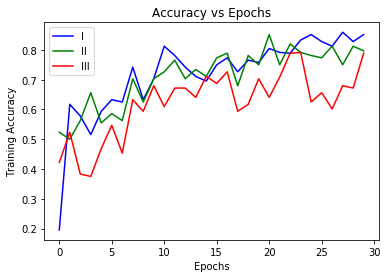

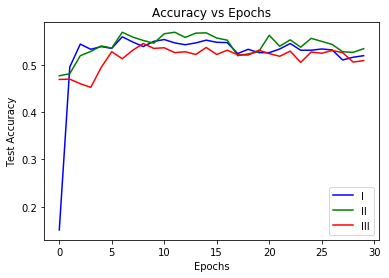

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(i_train_accuracies,'b',label='I')
plt.plot(ii_train_accuracies,'g',label='II')
plt.plot(iii_train_accuracies,'r',label='III')

plt.title('Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.savefig("part_2_B_training_graph.png")
plt.figure()

plt.plot(i_val_accuracies,'b',label='I')
plt.plot(ii_val_accuracies,'g',label='II')
plt.plot(iii_val_accuracies,'r',label='III')

plt.title('Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.savefig("part_2_B_test_graph.png")
plt.figure()